# Foundations of AI/ML by IIIT-Hyderabad & Talent Sprint
# Lab04 Experiment 1

For this lab, you will be working with very large datasets, so **kindly do not try to copy, move or download the datasets folder**. This will result in a drastic load on the network along with high utilization of your servers and slow down of everyones work.

# TEXT CLASSIFICATION

The aim of this exercise is to introduce concepts in the text classification pipeline. We will briefly go over the powerful notions of bag of words, PCA and word2vec. 

In this experiment we will be exploring the task of news classification, for which we use the 20 news classification dataset: http://archive.ics.uci.edu/ml/datasets/Twenty+Newsgroups.

## Understanding the data

To get a sense of our data, let us first start by counting the frequencies of the target classes in our news articles in the training set.

In [3]:
!pip3 install gensim    #required library for experiment

In [13]:
2+3

5

In [14]:
import pickle
dataset = pickle.load(open('../../Datasets/newsgroups.pkl','rb'))

In [15]:
print(dataset.keys())

dict_keys(['comp.sys.mac.hardware', 'talk.politics.misc', 'comp.windows.x', 'sci.crypt', 'sci.med', 'rec.motorcycles', 'comp.sys.ibm.pc.hardware', 'rec.sport.hockey', 'soc.religion.christian', 'comp.os.ms-windows.misc', 'rec.autos', 'comp.graphics', 'talk.politics.guns', 'talk.religion.misc', 'rec.sport.baseball', 'misc.forsale', 'alt.atheism', 'talk.politics.mideast', 'sci.electronics', 'sci.space'])


In [16]:
# Print frequencies of dataset
print("Class : count")
print("--------------")
number_of_documents = 0
total_items = 0
for key in dataset:
    print(key, ':', len(dataset[key]))
    total_items +=  len(dataset[key])
print(total_items)

Class : count
--------------
comp.sys.mac.hardware : 961
talk.politics.misc : 775
comp.windows.x : 980
sci.crypt : 991
sci.med : 990
rec.motorcycles : 994
comp.sys.ibm.pc.hardware : 982
rec.sport.hockey : 999
soc.religion.christian : 997
comp.os.ms-windows.misc : 985
rec.autos : 990
comp.graphics : 973
talk.politics.guns : 910
talk.religion.misc : 628
rec.sport.baseball : 994
misc.forsale : 972
alt.atheism : 799
talk.politics.mideast : 940
sci.electronics : 981
sci.space : 987
18828


## Splitting into train and test sets

Next, let us split our dataset which consists of 1000 samples per class, into training and test sets. We use 950 samples from each class in the training set, and the remaining 50 in the test set. 

As a mental exercise you should try reasoning about why is it important to ensure a nearly equal distribution of classes in your training and test sets. 

In [17]:
for k in dataset:
    split = int(0.95*len(dataset[k]))
    print(split)

912
736
931
941
940
944
932
949
947
935
940
924
864
596
944
923
759
893
931
937


#### Note : We are not keeping train or test labels when we split the data, which we used to do earlier.

In [18]:
train_set = {}
test_set = {}

# Clean dataset for text encoding issues :- Very useful when dealing with non-unicode characters
for key in dataset:
    dataset[key] = [[i.decode('utf-8', errors='replace').lower() for i in f] for f in dataset[key]]
    
# Break dataset into 95-5 split for training and testing
n_train = 0
n_test = 0
for k in dataset:
    split = int(0.95*len(dataset[k]))
    train_set[k] = dataset[k][0:split]
    test_set[k] = dataset[k][split:-1]
    n_train += len(train_set[k])
    n_test += len(test_set[k])

print(n_train)
print(n_test)

17878
930


# 1. Bag-of-Words

Let us begin our journey into text classification with one of the simplest but most commonly used feature representations for news documents - Bag-of-Words.

As you might have realized, machine learning algorithms need good feature representations of different inputs.  Concretely, we would like to represent each news article $D$ in terms of a feature vector $V$, which can be used for classification. Feature vector $V$ is made up of the number of occurences of each word in the vocabulary.

Let us begin by counting the number of occurences of every word in the news documents in the training set.

## 1.1 Word frequency

Let us try understanding the kind of words that appear frequently, and those that occur rarely. We now count the frequencies of words:

In [8]:
import re
import operator
from collections import defaultdict

frequency = defaultdict(int)

for key in train_set:
    print(key)
    for f  in train_set[key]:
        print(f)
        # Find all words which consist only of capital and lowercase characters and are between length of 2-9.
        # We ignore all special characters such as !.$ and words containing numbers
        words = re.findall(r'(\b[A-Za-z][a-z]{2,9}\b)', ' '.join(f))
        print(words)
        
        for word in words:
            frequency[word] += 1
        print('----------------------------')
        print("Frquency of all of the words : ")
        print(frequency)
        break
    print("-------------")
    print("Sort by the frequency of words:")
    # sorted by the frequency of items
    sorted_words = sorted(frequency.items(), key=operator.itemgetter(1), reverse=True)
    print(sorted_words)
    print('----------------------------')
    print("Top-10 most frequent words:")
    for word in sorted_words[:10]:
        print(word)
        
    print('----------------------------')
    print("10 least frequent words:")
    for word in sorted_words[-10:-1]:
        print(word)
    break

comp.sys.mac.hardware
['from: walsteyn@fys.ruu.nl (fred walsteijn)\n', 'subject: re: built-in video problems on mac iisi !!??!!\n', '\n', 'in <1993apr19.164611.1018@fys.ruu.nl> walsteyn@fys.ruu.nl (fred walsteijn) writes:\n', '\n', ">i've seen the following problem om three mac iisi machines\n", '>all with 17 mb ram installed (70 or 80 ns simms).\n', '\n', '>if the contents of a window are being calculated and updated\n', '>a lot of strange horizontal lines are temporarily generated\n', '>on the screen.  the lines translate to the top of the screen and\n', '>have a slightly lower brightness than their surroundings (they\n', '>are a few millimeters apart).\n', '>i admit that they are vague, but they can still be distinguished clearly,\n', '>especially if the environment (i.e. the rest of the room) is a bit dark.\n', '>applications which produce this effect are:\n', '>- the previewer of directtex 1.2 (i.e. dvireader 1.2)\n', '>- kaleidagraph 2.1.1/fpu\n', '\n', 'another program which pro

In [9]:
import re
import operator

from collections import defaultdict

# Initialize a dictionary to store frequencies of words.
# Key:Value === Word:Count
frequency = defaultdict(int)
    
for key in train_set:
    for f in train_set[key]:
        
        # Find all words which consist only of capital and lowercase characters and are between length of 2-9.
        # We ignore all special characters such as !.$ and words containing numbers
        words = re.findall(r'(\b[A-Za-z][a-z]{2,9}\b)', ' '.join(f))
    
        for word in words:
            frequency[word] += 1

sorted_words = sorted(frequency.items(), key=operator.itemgetter(1), reverse=True)
print("Top-10 most frequent words:")
for word in sorted_words[:10]:
    print(word)

print('----------------------------')
print("10 least frequent words:")
for word in sorted_words[-10:-1]:
    print(word)

Top-10 most frequent words:
('the', 226860)
('and', 90621)
('that', 62088)
('for', 43546)
('you', 42430)
('from', 35358)
('this', 31001)
('not', 28645)
('have', 28519)
('are', 28355)
----------------------------
10 least frequent words:
('slashfive', 1)
('inbvrvz', 1)
('appshell', 1)
('lyg', 1)
('proulx', 1)
('moree', 1)
('wiggles', 1)
('fettucine', 1)
('microlife', 1)


Next, we attempt to plot a histogram of the counts of various words in descending order. 

Could you comment about the relationship between the frequency of the most frequent word to the second frequent word? 
And what about the third most frequent word?

(Hint - Check the relative frequencies of the first, second and third most frequent words)

(After answering, you can visit https://en.wikipedia.org/wiki/Zipf%27s_law for further Reading)

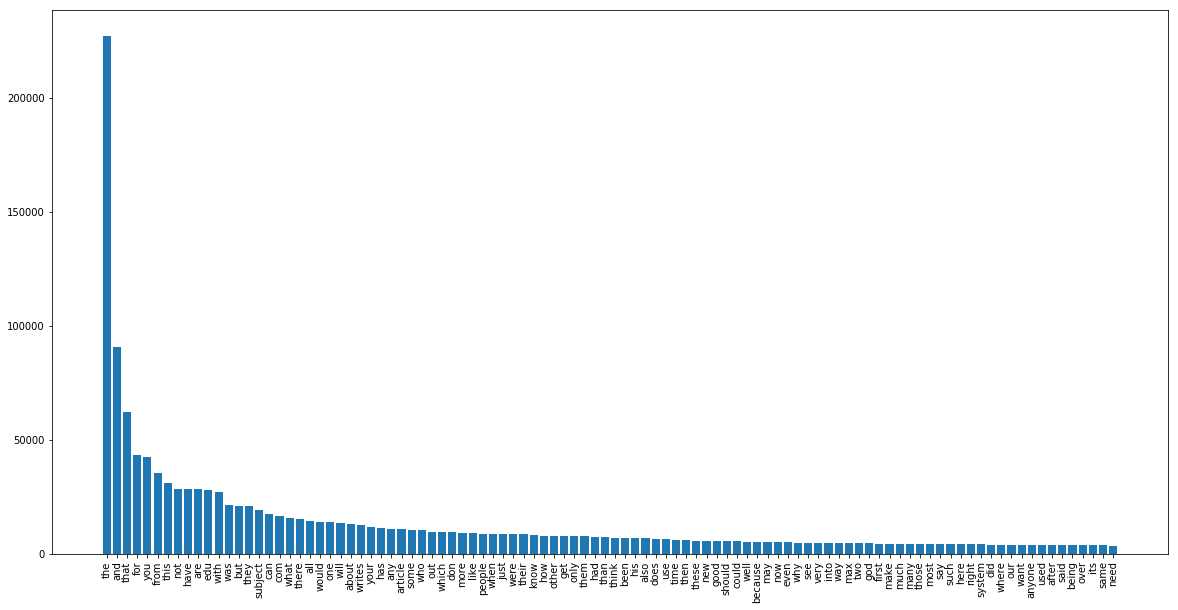

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline  

fig = plt.figure()
fig.set_size_inches(20,10)

plt.bar(range(len(sorted_words[:100])), [v for k, v in sorted_words[:100]] , align='center')
plt.xticks(range(len(sorted_words[:100])), [k for k, v in sorted_words[:100]])
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.show()

## 1.2 Pre-processing to remove most and least frequent words

We can see that different words appear with different frequencies.

The most common words appear in almost all documents. Hence, for a classification task, having information about those words' frequencies does not mater much since they appear frequently in every type of document. To get a good feature representation, we eliminate them since they do not add too much value.

Additionally, notice how the least frequent words appear so rarely that they might not be useful either.

Let us pre-process our news articles now to remove the most frequent and least frequent words by thresholding their counts: 

In [11]:
sorted_words[26]

('your', 11694)

In [12]:
valid_words = defaultdict(int)
print(valid_words)
print('Number of words before preprocessing:', len(sorted_words))

# Ignore the 25 most frequent words, and the words which appear less than 100 times
ignore_most_frequent = 25
freq_thresh = 100 # ignore words which appear less than 100 times

feature_number = 0
for word, word_frequency in sorted_words[ignore_most_frequent:]:
    if word_frequency > freq_thresh:
        valid_words[word] = feature_number
        feature_number += 1
        
print('Number of words after preprocessing:', len(valid_words))
word_vector_size = len(valid_words)

defaultdict(<class 'int'>, {})
Number of words before preprocessing: 89599
Number of words after preprocessing: 4096


In [13]:
valid_words = defaultdict(int)

print('Number of words before preprocessing:', len(sorted_words))

# Ignore the 25 most frequent words, and the words which appear less than 100 times
ignore_most_frequent = 25
freq_thresh = 100 # ignore words which appear less than 100 times
feature_number = 0
for word, word_frequency in sorted_words[ignore_most_frequent:]:
    if word_frequency > freq_thresh:
        valid_words[word] = feature_number
        feature_number += 1
        
print('Number of words after preprocessing:', len(valid_words))

word_vector_size = len(valid_words)

Number of words before preprocessing: 89599
Number of words after preprocessing: 4096


## 1.3 Bag-of-Words representation

The simplest way to represent a document $D$ as a vector $V$ would be to now count the relevant words in the document. 

For each document, make a vector of the count of each of the words in the vocabulary (excluding the words removed in the previous step - the "stopwords").

In [14]:
labels

<a list of 100 Text xticklabel objects>

In [33]:
import numpy as np

def convert_to_BoW(dataset, number_of_documents):
    print(word_vector_size)
    bow_representation = np.zeros((number_of_documents, word_vector_size))
    labels = np.zeros((number_of_documents, 1))
    
    i = 0
    for label, class_name in enumerate(dataset):
        
        # For each file
        for f in dataset[class_name]:
            
            # Read all text in file
            text = ' '.join(f).split(' ')
            
            # For each word
            for word in text:
                if word in valid_words:
                    bow_representation[i, valid_words[word]] += 1
            
            # Label of document
            labels[i] = label
            
            # Increment document counter
            i += 1
    
    return bow_representation, labels

# Convert the dataset into their bag of words representation treating train and test separately
train_bow_set, train_bow_labels = convert_to_BoW(train_set, n_train)
test_bow_set, test_bow_labels = convert_to_BoW(test_set, n_test)

4096
4096


## 1.4 Document classification using Bag-of-Words

For the test documents, use your favorite distance metric (Cosine, Eucilidean, etc.) to find similar news articles from your training set and classify using kNN.

In [16]:
import math
import collections

# Optimized K-NN:- This does the same thing as you've learned but in an optimized manner
def dist(train_features, given_feature):
    squared_difference = (train_features - given_feature)**2
    distances = np.sqrt(np.sum(squared_difference, axis = 1))
    return distances

''' 
 Optimized K-NN code. This code is the same as what you've already seen, but trades off memory efficency 
 for computational efficency. 
'''
def kNN(k, train_features, train_labels, given_feature):
    distances = []
    
    n = train_features.shape[0]
    
    # np.tile function repeats the given_feature n times.
    given_feature = np.tile(given_feature, (n, 1))
    
    # Compute distance
    distances = dist(train_features, given_feature)
    sort_neighbors = np.argsort(distances)
    return np.concatenate((distances[sort_neighbors][:k].reshape(-1, 1), train_labels[sort_neighbors][:k].reshape(-1, 1)), axis = 1)

def kNN_classify(k, train_features, train_labels, given_feature):
    tally = collections.Counter()
    tally.update(str(int(nn[1])) for nn in kNN(k, train_features, train_labels, given_feature))
    return int(tally.most_common(1)[0][0])

For example, using 3 nearest neighbours, the $0^{th}$ test document is classified as:

In [17]:
kNN_classify(3, train_bow_set, train_bow_labels, test_bow_set[0])

0

Compute accuracy for the bag-of-words features on the full test set:

In [18]:
accuracy = 0
for i, given_feature in enumerate(test_bow_set):
    print("Progress: {0:.04f}".format((i+1)/len(test_bow_set)), end="\r")
    predicted_class = kNN_classify(3, train_bow_set, train_bow_labels, given_feature)
    if predicted_class == int(test_bow_labels[i]):
        accuracy += 1
print(accuracy / len(test_bow_set))

0.4881720430107527


# 2. Word2Vec

In the previous section we saw a naive way to represent words as dense vectors which can leverage the semantics of the words.

The problem with count-based word representations is that they are costly in terms of memory to compute large co-occurrence matrices. Let us see another method to find representations of words without explicitly counting words.

Here, we aim to predict the next word given the context in which the word appears. (For example, given the last $n$ words, predict the next word). A very smart way to do this is by using a feature representation called "Word2Vec" with transforms each word into 300-dimensional vectors.

Link to pretrained 300 dimensional word2vec: https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM&export=download

## 2.1 Visualizations

Before we go to the actual 300 dimensional vectors, let's try to explore some of the more intriguing properties of word2vec.

You have been provided with a sample of word vectors. **We have reduced the dimensionality of the 300-dimensional vectors to 2 dimensions, so that we can plot them in matplotlib.**

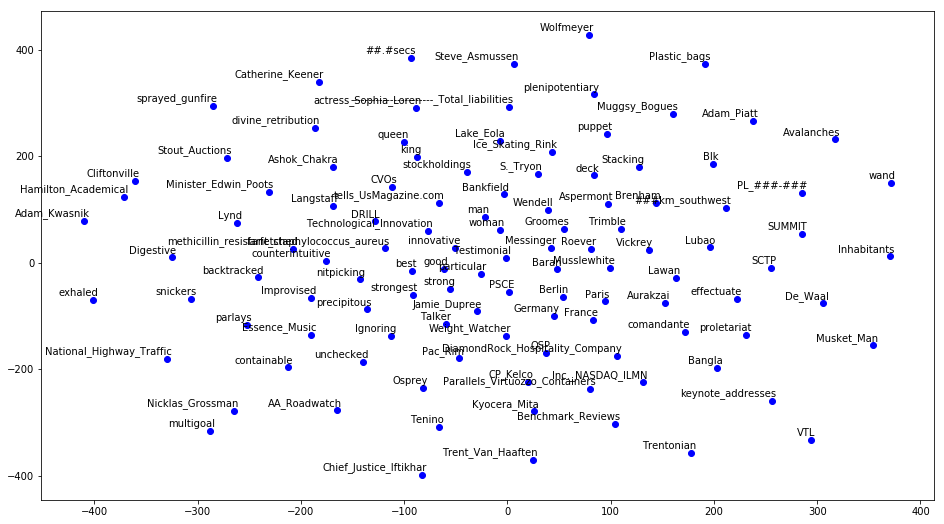

In [19]:
def plot_values(values, labels, figsize = (8,4), c = []):
    x = []
    y = []
    for value in values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=figsize) 
    for i in range(len(labels)):
        plt.scatter(x[i],y[i], color=c[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()


import pickle
two_dim_model = pickle.load(open('../../Datasets/word2vec2d.pkl', 'rb'))

wv_labels = {}
for vec, word in two_dim_model:
    wv_labels[word] = vec
    
colors = ['blue' for i in range(len(wv_labels))]

plot_values(wv_labels.values(), list(wv_labels.keys()), figsize = (16, 9), c = colors)

Now, we have given you the 2D representation of different word vectors. Plot the word vectors for the words 'King', 'Queen', 'man', 'women', 'Germany', 'France', 'Berlin', 'Paris', 'best', 'good', 'strong', 'strongest' in green color:

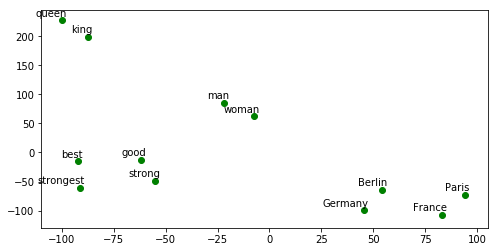

In [20]:
wv_list = ['king', 'queen', 'man', 'woman', 'Germany', 'France', 'Berlin', 'Paris', 'best', 'good', 'strong', 'strongest']
wv_new_labels = {}
for word in wv_list:
    wv_new_labels[word] = wv_labels[word]

colors = ['green' for i in range(len(wv_new_labels))]
plot_values(wv_new_labels.values(), list(wv_new_labels.keys()), c = colors)

Consider the word analogy question: "Queen is to King, as Woman is to what?"

To answer this question, we aim to find what the difference between a "King" and "Queen" is, and apply that difference to a "Woman". If we try to put this mathematically, we can write:- 
$$
 Answer = Woman + Queen - King
$$

Compute the value of the vector on the right hand side of the above equation and plot the resulting vector in red in the same plot as before. 

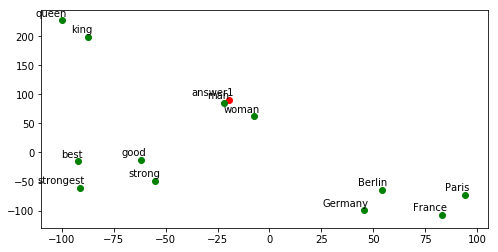

In [21]:
answer = wv_new_labels['woman']  + wv_new_labels['queen'] - wv_new_labels['king']

wv_new_labels['answer1'] = answer

colors = ['green' if word not in ['answer1'] else 'red' for word in wv_new_labels]

plot_values(wv_new_labels.values(), list(wv_new_labels.keys()), c = colors)

Notice how the answer vector is very close to the vector of the word "Man"? Incidentally, "Man" is the right answer to the word analogy question! This is the power of Word2Vec representations.

### Exercise 0

Using this technique answer the following questions.

* Germany is to France, as Paris is to?
* Best is to Good, as Strongest is to?


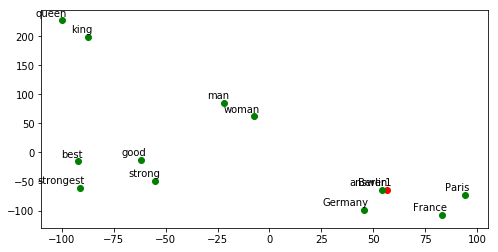

In [24]:
answer = wv_new_labels['Paris']  + wv_new_labels['Germany'] - wv_new_labels['France']

wv_new_labels['answer1'] = answer

colors = ['green' if word not in ['answer1'] else 'red' for word in wv_new_labels]

plot_values(wv_new_labels.values(), list(wv_new_labels.keys()), c = colors)

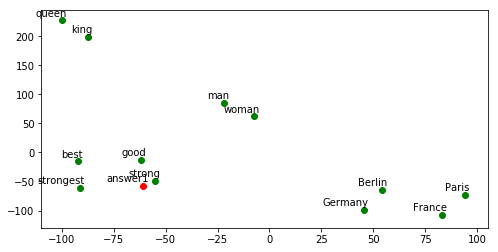

In [29]:
answer = wv_new_labels['strongest']  + wv_new_labels['good'] - wv_new_labels['best']

wv_new_labels['answer1'] = answer

colors = ['green' if word not in ['answer1'] else 'red' for word in wv_new_labels]

plot_values(wv_new_labels.values(), list(wv_new_labels.keys()), c = colors)

## 2.2 Load pre-trained Word2Vec

Let us now proceed to load the complete pretrained vectors.

In [19]:
import gensim
model = gensim.models.KeyedVectors.load_word2vec_format('../../Datasets/GoogleNews-vectors-negative300.bin', binary=True, limit=500000)

## 2.3 Word2Vec representation

Convert each document into average of the word2vec vectors of all valid words in document

In [1]:
import numpy as np

word2vec_vector_size = 300

'''
 This method converts documents to word vectors. It first checks if the word is valid according to our initial frequency 
 threshold. Next, if it is, we add the precomputed word vectors together. If the word is valid, but we do not have a valid 
 vector to represent the word, we add a random gaussian noise instead. Since we do not want to induce new noise each time,
 we store the same noise vector for training and test time in substitute_word_vecs variable.
'''
def convert_to_w2v(dataset, number_of_documents, substitute_word_vecs={}):
    labels = np.zeros((number_of_documents, 1))
    w2v_rep = np.zeros((number_of_documents, word2vec_vector_size))
    
    # Iterate over the dataset and split into words
    i = 0
    for label, class_name in enumerate(dataset):
        for f in dataset[class_name]:
            text = ' '.join(f).split(' ')
            valid_count = 1
            for word in text:
                
                # Check if word is valid or not according to original dataset pruning
                if word in valid_words:
                    try:
                        w2v_rep[i] += model[word]
                    except:
                        '''The word isn't in our pretrained word-vectors, hence we add a random gaussian noise
                         to account for this. We store the random vector we assigned to the word, and reuse 
                         the same vector during test time to ensure consistency.'''
                        
                        if word not in substitute_word_vecs.keys():
                            # substitute_word_vecs[word] = np.random.normal(-0.25, 0.25, word2vec_vector_size)
                            substitute_word_vecs[word] = np.zeros(word2vec_vector_size)
                            
                        w2v_rep[i] += substitute_word_vecs[word]
                    
                    valid_count += 1
            
            # Average
            w2v_rep[i] = w2v_rep[i] / valid_count
            
            # Save label
            labels[i] = label
            
            i += 1
    
    return w2v_rep, labels, substitute_word_vecs

# Convert the train and test datasets into their word2vec representations
train_w2v_set, train_w2v_labels, substitute_word_vecs = convert_to_w2v(train_set, n_train)
test_w2v_set, test_w2v_labels,_ = convert_to_w2v(test_set, n_test, substitute_word_vecs)

NameError: name 'train_set' is not defined

## 2.4 Document classification using Word2Vec

For the test documents, use your favorite distance metric (Cosine, Eucilidean, etc.) to find similar news articles from your training set and classify using kNN.

In [32]:
accuracy = 0
for i, given_feature in enumerate(test_w2v_set):
    print("Progress: {0:.04f}".format((i+1)/len(test_w2v_set)), end="\r")
    predicted_class = kNN_classify(3, train_w2v_set, train_w2v_labels, given_feature)
    if predicted_class == int(test_w2v_labels[i]):
        accuracy += 1
print(accuracy / len(test_w2v_set))

0.6591397849462366


### Exercise 1 

The frequency thresholds represents the minimum frequency a word must have to be considered relevant. Experiment with the following values of frequency threshold in your preprocessing step from section 1.2. Re-run all the codes with the new set of valid words and report the accuracies. Use the following values:

`freq_thresh` = 
* 0
* 1000

Report the accuracies using both bag of words and word2vec features.

In [35]:
# bag of words 




# Ignore the 25 most frequent words, and the words which appear less than 100 times

for freq_thresh in [1000]: # ignore words which appear less than 100 times
    ignore_most_frequent = 25
    feature_number = 0
    
    valid_words = defaultdict(int)
    
    print('Number of words before preprocessing:', len(sorted_words))        
    for word, word_frequency in sorted_words[ignore_most_frequent:]:
        if word_frequency > freq_thresh:
            valid_words[word] = feature_number
            feature_number += 1
        
    print('Number of words after preprocessing:', len(valid_words))

    word_vector_size = len(valid_words)
    
    # Convert the dataset into their bag of words representation treating train and test separately
    train_bow_set, train_bow_labels = convert_to_BoW(train_set, n_train)
    test_bow_set, test_bow_labels = convert_to_BoW(test_set, n_test)
    
    accuracy = 0
    for i, given_feature in enumerate(test_bow_set):
        print("Progress: {0:.04f}".format((i+1)/len(test_bow_set)), end="\r")
        predicted_class = kNN_classify(3, train_bow_set, train_bow_labels, given_feature)
        if predicted_class == int(test_bow_labels[i]):
            accuracy += 1
    print(accuracy / len(test_bow_set))

Number of words before preprocessing: 89599
Number of words after preprocessing: 426
426
426
0.3913978494623656


### Exercise 2

In section 2.3, substitute_word_vectors is used as a proxy for a word vector which we do not know. We used a normal gaussian to represent this in that section. Experiment with the type of substitute word vectors used when you do not have a pretrained word vector. Use with the following:

`substitute_word_vecs` : 
* np.ones
* np.zeros

Report the accuracies using only word2vec features.

### Exercise 3

To classify news articles into their 20 news groups, experiment with three different classifiers with the following parameter choices.

* K-NN 
 ** K : 10, 50
 ** Distance Metric : Euclidean.

* Naive Bayes
 ** Probability Distribution assumption : Gaussian.
 
* Multiclass Linear classifier.

Report the accuracies using both bag of words and word2vec features.

### Exercise 4

Report your final accuracies on each classifier in terms of TP, FP, Precision, Recall and F-scores using both bag of words and word2vec features. 

You should have a table in the following format:

Mthd | Bag  | of | Words | --- | Word |  2 | Vec | --- 
---- | -    | -  | -     |  -  |  -   |  - |  -  |  -
Mtrc | TP   | FP | P     |  R  |  TP  | FP |  P  |  R  
KNN  | -    | -  | -     |  -  | -    |  - | -   |  - 
NB   | -    | -  | -     |  -  | -    |  - | -   |- 
MLC  | -    | -  | -     |  -  | -    |  - | -   |- 
